## DR11 Sky-subtraction tests

In [2]:
import os, warnings
import numpy as np
import fitsio
import multiprocessing
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales as get_pixscale
from photutils.aperture import EllipticalAperture, aperture_photometry
from photutils.isophote import (EllipseGeometry, EllipseSample, Isophote, IsophoteList)

#### SGA geometry for NGC 4254
https://www.legacysurvey.org/viewer-dev?ra=184.7061&dec=14.4169&layer=ls-dr9&zoom=13&sga

In [3]:
ra, dec = 184.706635, 14.416662
diam, ba, pa = 6.015 * 60., 0.93, 63. # diam in arcsec

In [4]:
bands = ['g', 'r', 'z']
refband = 'r'
nsma = 32 # number of samples along the semi-major axis

#### I/O and basic geometry tools

In [5]:
def read_data(datadir):
    jpg = mpimg.imread(os.path.join(datadir, f'legacysurvey-1847p145-image.jpg'))

    reffile = os.path.join(datadir, f'legacysurvey-1847p145-image-{refband}.fits.fz')
    hdr = fits.getheader(reffile, ext=1)
    width = hdr['NAXIS1']
    wcs = WCS(hdr)
    pixscale = get_pixscale(wcs)[0] * width # [arcsec/pixel]

    imgs = []
    for band in bands:
        img = fitsio.read(os.path.join(datadir, f'legacysurvey-1847p145-image-{band}.fits.fz'))
        img /= pixscale**2 # [nanomaggies/arcsec2]
        if band == refband:
            refimg = img
        imgs.append(img)

    return refimg, imgs, jpg, width, wcs, pixscale

In [6]:
def get_geometry(wcs, pixscale, ra, dec, diam, ba, pa):
    (x0, y0) = wcs.wcs_world2pix(ra, dec, 1)
    semia = diam / 2. / pixscale # [pixels]
    eps = 1. - ba
    theta = np.radians(pa - 90.) # CCW from x-axis
    geo = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=semia, pa=theta)
    return geo

In [7]:
def qa_geometry(jpg, g):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(np.flipud(jpg), origin='lower', cmap='inferno')
    ax.axis('off')
    ap = EllipticalAperture((g.x0, g.y0), g.sma, g.sma * (1. - g.eps), g.pa)
    ap.plot(color='cyan', lw=2)

#### Surface-brightness tools

In [8]:
def _integrate_isophot_one(args):
    """Wrapper function for the multiprocessing."""
    return integrate_isophot_one(*args)

In [9]:
def integrate_isophot_one(img, sma, theta, eps, x0, y0,
                          integrmode, sclip, nclip):
    """Integrate the ellipse profile at a single semi-major axis."""
    import copy
    g = EllipseGeometry(x0=x0, y0=y0, eps=eps, sma=sma, pa=theta)

    # Use the same integration mode and clipping parameters.
    # The central pixel is a special case:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        if g.sma == 0.0:
            gcen = copy.deepcopy(g)
            gcen.sma = 0.0
            gcen.eps = 0.0
            gcen.pa = 0.0
            censamp = CentralEllipseSample(img, 0.0, geometry=gcen,
                                           integrmode=integrmode, sclip=sclip, nclip=nclip)
            out = CentralEllipseFitter(censamp).fit()
        else:
            sample = EllipseSample(img, sma=g.sma, geometry=g, integrmode=integrmode,
                                   sclip=sclip, nclip=nclip)
            sample.update(fixed_parameters=True)
            #print(filt, g.sma, sample.mean)

            # Create an Isophote instance with the sample.
            out = Isophote(sample, 0, True, 0)
    return out

In [10]:
    COLS = ['sma', 'intens', 'intens_err', 'eps', 'eps_err',
            'pa', 'pa_err', 'x0', 'x0_err', 'y0', 'y0_err',
            'a3', 'a3_err', 'a4', 'a4_err', 'rms', 'pix_stddev',
            'stop_code', 'ndata', 'nflag', 'niter']
    DTYPES = [np.int16, np.float32, np.float32, np.float32, np.float32,
              np.float32, np.float32, np.float32, np.float32, np.float32, np.float32,
              np.float32, np.float32, np.float32, np.float32, np.float32, np.float32,
              np.int16, np.int16, np.int16, np.int16]
print(len(COLS), len(DTYPES))

21 21


In [11]:
def _unpack_isofit(isofit, filt):
    """Unpack the IsophotList objects into a dictionary."""
    COLS = ['sma', 'intens', 'intens_err', 'eps', 'eps_err',
            'pa', 'pa_err', 'x0', 'x0_err', 'y0', 'y0_err',
            'a3', 'a3_err', 'a4', 'a4_err', 'rms', 'pix_stddev',
            'stop_code', 'ndata', 'nflag', 'niter']
    DTYPES = [np.float32, np.float32, np.float32, np.float32, np.float32,
              np.float32, np.float32, np.float32, np.float32, np.float32, np.float32,
              np.float32, np.float32, np.float32, np.float32, np.float32, np.float32,
              np.int16, np.int16, np.int16, np.int16]
    
    I = np.isfinite(isofit.intens) * np.isfinite(isofit.int_err)    
    values = [isofit.sma[I], isofit.intens[I], isofit.int_err[I], isofit.eps[I], isofit.ellip_err[I],
              isofit.pa[I], isofit.pa_err[I], isofit.x0[I], isofit.x0_err[I], isofit.y0[I], isofit.y0_err[I],
              isofit.a3[I], isofit.a3_err[I], isofit.a4[I], isofit.a4_err[I], isofit.rms[I], isofit.pix_stddev[I],
              isofit.stop_code[I], isofit.ndata[I], isofit.nflag[I], isofit.niter[I]]
    data = {}
    for col, dtype, value in zip(COLS, DTYPES, values):
        data[f'{col}_{filt.lower()}'] = value.astype(dtype)
    return data

In [12]:
def do_ellipse(bands, imgs, refgeo, nsma=32, mp=8, integrmode='median', sclip=2.5, nclip=5):
    smas = refgeo.sma * np.linspace(0.01, 2.5, nsma)

    data = {}
    for band, img in zip(bands, imgs):
        print(f'Working on band {band}')
        with multiprocessing.Pool(mp) as P:
            iso = P.map(_integrate_isophot_one, [(img, sma, refgeo.pa, refgeo.eps, refgeo.x0, refgeo.y0,
                                                  integrmode, sclip, nclip) for sma in smas])
        res = _unpack_isofit(IsophoteList(iso), band)
        data.update(res)
    return data

In [13]:
def qa_ellipse(data, jpg, refgeo, nsma=32, title=None):

    smas = refgeo.sma * np.linspace(0.01, 2.5, nsma)
    refap = EllipticalAperture((refgeo.x0, refgeo.y0), refgeo.sma,
                                refgeo.sma * (1. - refgeo.eps), refgeo.pa)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

    ax1.imshow(np.flipud(jpg), origin='lower', cmap='inferno')
    ax1.axis('off')
    for sma in smas:
        g = EllipseGeometry(x0=refgeo.x0, y0=refgeo.y0, eps=refgeo.eps, sma=sma, pa=refgeo.pa)
        ap = EllipticalAperture((g.x0, g.y0), g.sma,
                         g.sma * (1. - g.eps), g.pa)
        ap.plot(color='white', lw=1, ax=ax1)
    refap.plot(color='cyan', lw=2, ls='--', ax=ax1)

    for band in bands:
        ax2.scatter(pixscale*data[f'sma_{band}'], data[f'intens_{band}'], label=band)
    ax2.set_yscale('log')
    ax2.legend(loc='upper right')

    for band in bands:
        ax3.scatter(pixscale*data[f'sma_{band}'], data[f'intens_{band}'])
    ax3.axhline(y=0, color='gray')

    last = np.abs(data[f'intens_{refband}'][-1])
    ax3.set_ylim(-3*last, 10*last)

    for xx in (ax2, ax3):
        xx.axvline(x=diam/2., color='cyan', lw=2, ls='--', label='R(26) [SGA-2020]')
        xx.set_xlabel('Semi-major axis (arcsec)')
        xx.set_ylabel(r'Isophotal flux (nanomaggies arcsec$^{-2}$)')

    ax3.legend(loc='upper right')

    fig.suptitle(title)
    fig.tight_layout()

#### Background statistics
https://photutils.readthedocs.io/en/stable/user_guide/background.html

In [22]:
def get_background(bands, imgs):
    from astropy.stats import sigma_clipped_stats, SigmaClip
    from photutils.segmentation import detect_threshold, detect_sources
    from photutils.utils import circular_footprint
    from photutils.background import (Background2D, MedianBackground, SExtractorBackground, 
                                      BkgIDWInterpolator, BkgZoomInterpolator)

    sigma_clip = SigmaClip(sigma=2.5, maxiters=10)
    footprint = circular_footprint(radius=10.)
    #bkg_estimator = SExtractorBackground()#sigma_clip=sigma_clip) # MedianBackground()
    bkg_estimator = MedianBackground()
    
    bkg = {}
    for iband, band in enumerate(bands):
        img = imgs[iband]
        threshold = detect_threshold(img, nsigma=2.0, sigma_clip=sigma_clip)
        segment_img = detect_sources(img, threshold, npixels=10)
        mask = segment_img.make_source_mask(footprint=footprint)
        mn, med, std = sigma_clipped_stats(img, sigma=2.5, mask=mask)

        sky = Background2D(img, (75, 75), mask=mask, filter_size=(3, 3),
                           sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,
                           interpolator=BkgZoomInterpolator(order=1))
        
        bkg[band] = img[~mask]
        bkg[f'{band}_mask'] = mask
        bkg[f'{band}_sky'] = sky
        bkg[f'{band}_mean'] = mn
        bkg[f'{band}_median'] = med
        bkg[f'{band}_std'] = std
        print(f'{band}-band: mean={mn:.6f}, median={med:.6f}, sigma={std:.6f}')
        
    return bkg

In [26]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

def qa_bkg(bkg, bands, refband='r', title=None):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    norm = ImageNormalize(stretch=SqrtStretch())

    sky = bkg[f'{refband}_sky']

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(2, 2, figure=fig, wspace=0.05, hspace=0.05)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    ax1.imshow(bkg[f'{refband}_mask'], origin='lower')
    ax1.axis('off')

    im = ax2.imshow(sky.background, origin='lower', interpolation='nearest',
                    cmap='inferno', norm=norm)
    ax2.axis('off')

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cax = inset_axes(ax2,
        width="3%",    # colorbar width
        height="100%", # match ax2 height
        loc='right',
        bbox_to_anchor=(0.1, 0, 1, 1),  # <-- shift right to x=1.10 (10% outside)
        bbox_transform=ax2.transAxes,
        borderpad=0
    )
    fig.colorbar(im, cax=cax, label=f'{refband}-band Background ' + r'(nanomaggies arcsec$^{-2}$)')

    for band in bands:
        ax3.hist(bkg[band], bins=100, log=True, fill=False, histtype='step', label=band)
    ax3.axvline(x=0, color='k')
    ax3.legend(loc='upper left')
    ax3.set_ylabel('Number')
    ax3.set_xlabel(r'Background Level (nanomaggies arcsec$^{-2}$)')

    xlim = [bkg[f'{refband}_mean'] - 5. * bkg[f'{refband}_std'],
            bkg[f'{refband}_mean'] + 5. * bkg[f'{refband}_std']]
    for band in bands:
        ax4.hist(bkg[band], bins=100, log=True, fill=False,
                 histtype='step', range=xlim)
    ax4.set_xlim(xlim)
    ax4.set_ylim(ax3.get_ylim())
    ax4.axvline(x=0, color='k', label='sky=0')
    for iband, band in enumerate(bands):
        med = bkg[f'{band}_median']
        ax4.axvline(x=med, ls='-', color=colors[iband], label=f'median {band} sky={med:.4f}')
    ax4.legend(loc='upper left', fontsize=8)
    ax4.set_yticks([])
    ax4.set_xlabel(r'Background Level (nanomaggies arcsec$^{-2}$)')

    fig.suptitle(title)

### Fitting results for each set of reductions

In [36]:
hdr = fitsio.read_header('/pscratch/sd/d/dstn/dr11-sky/constant-no-sga-2/coadd/184/1847p145/legacysurvey-1847p145-ccds.fits', 1)
hdr


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  399 / width of table in bytes
NAXIS2  =                   63 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   59 / number of fields in each row
TTYPE1  = 'image_filename'     / label for field   1
TFORM1  = '65A'                / data format of field: ASCII Character
TTYPE2  = 'image_hdu'          / label for field   2
TFORM2  = 'I'                  / data format of field: 2-byte INTEGER
TTYPE3  = 'camera'             / label for field   3
TFORM3  = '5A'                 / data format of field: ASCII Character
TTYPE4  = 'expnum'             / label for field   4
TFORM4  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE5  = 'plver'              / label for

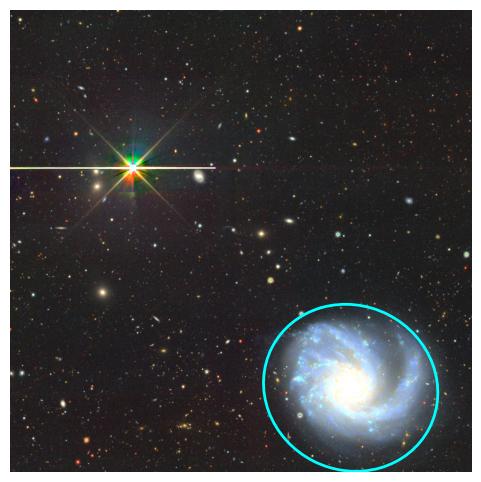

In [14]:
datadir1 = '/pscratch/sd/d/dstn/dr11-sky/constant-no-sga-2/coadd/184/1847p145'
refimg1, imgs1, jpg1, width, wcs, pixscale = read_data(datadir1)
refgeo = get_geometry(wcs, pixscale, ra, dec, diam, ba, pa)
qa_geometry(jpg1, refgeo)

In [15]:
%time data1 = do_ellipse(bands, imgs1, refgeo, nsma=nsma, mp=8)

Working on band g
Working on band r
Working on band z
CPU times: user 4.91 s, sys: 16.8 s, total: 21.7 s
Wall time: 2min 25s


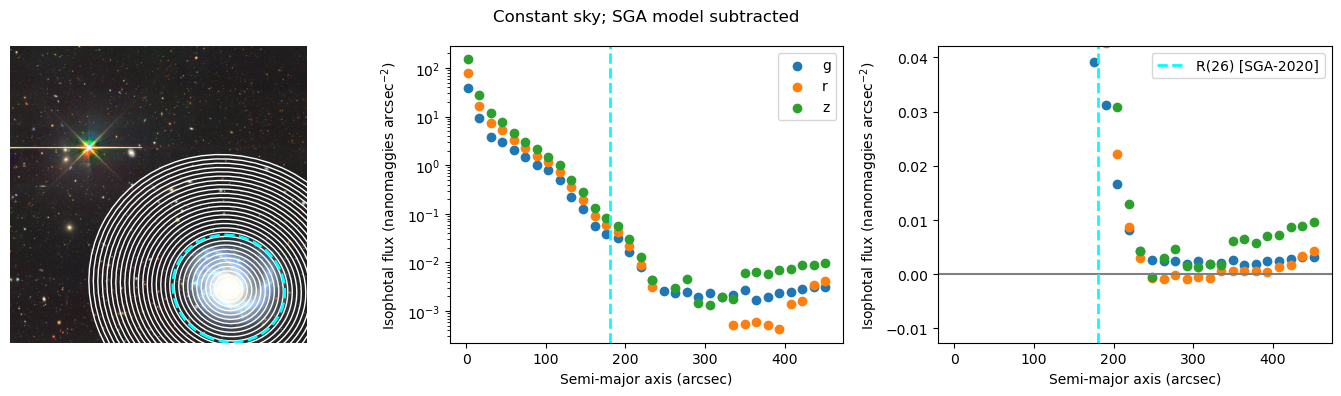

In [16]:
qa_ellipse(data1, jpg1, refgeo, nsma=nsma, title='Constant sky; SGA model subtracted')

/global/cfs/cdirs/cosmo/work/legacysurvey/dr11-early-v2/coadd/

In [23]:
%time bkg = get_background(bands, imgs1)

g-band: mean=0.003316, median=0.003130, sigma=0.034990
r-band: mean=0.002896, median=0.002521, sigma=0.058583
z-band: mean=0.010596, median=0.010061, sigma=0.147983
CPU times: user 14.9 s, sys: 3.84 s, total: 18.8 s
Wall time: 18.8 s


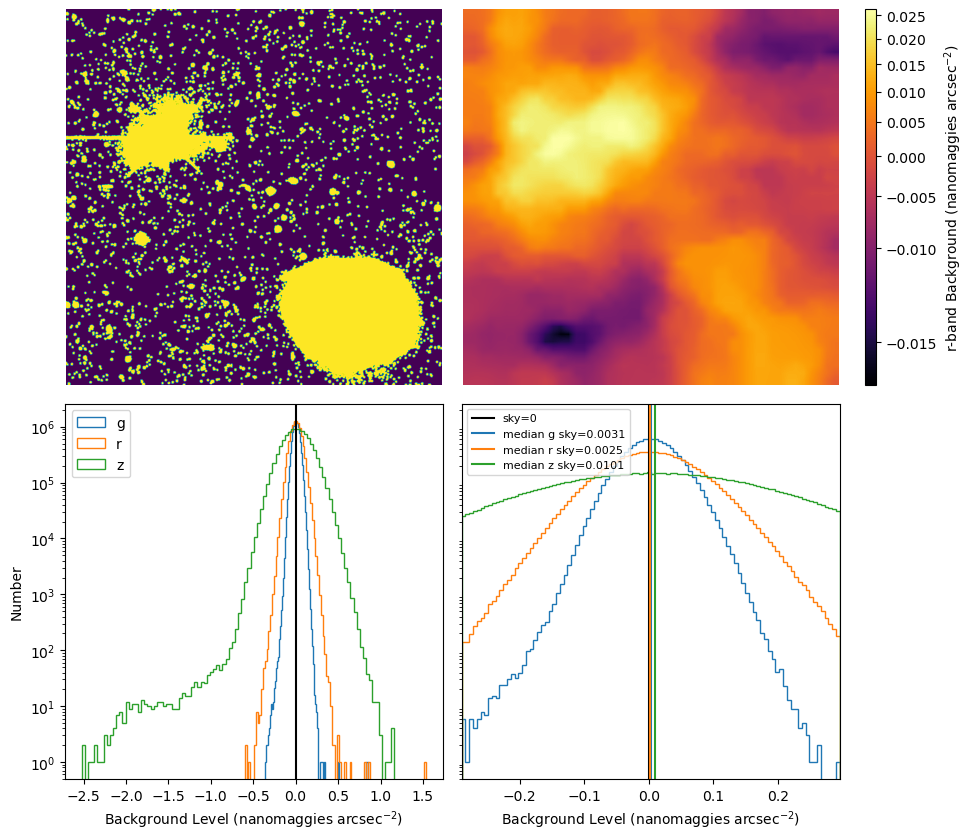

In [27]:
qa_bkg(bkg, bands)

In [ ]:
stop

#### Constant sky; SGA model subtracted

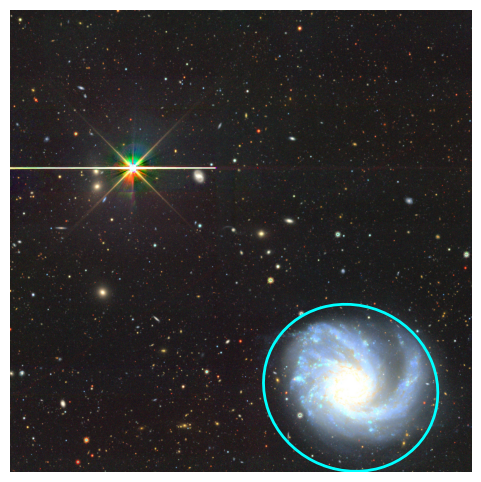

In [16]:
datadir1 = '/pscratch/sd/d/dstn/dr11-sky/constant/coadd/184/1847p145'
refimg1, imgs1, jpg1, width, wcs, pixscale = read_data(datadir1)
refgeo = get_geometry(wcs, pixscale, ra, dec, diam, ba, pa)
qa_geometry(jpg1, refgeo)

In [17]:
%time data1 = do_ellipse(bands, imgs1, refgeo, nsma=nsma, mp=8)

Working on band g
Working on band r
Working on band z
CPU times: user 8.05 s, sys: 23.4 s, total: 31.4 s
Wall time: 3min 41s


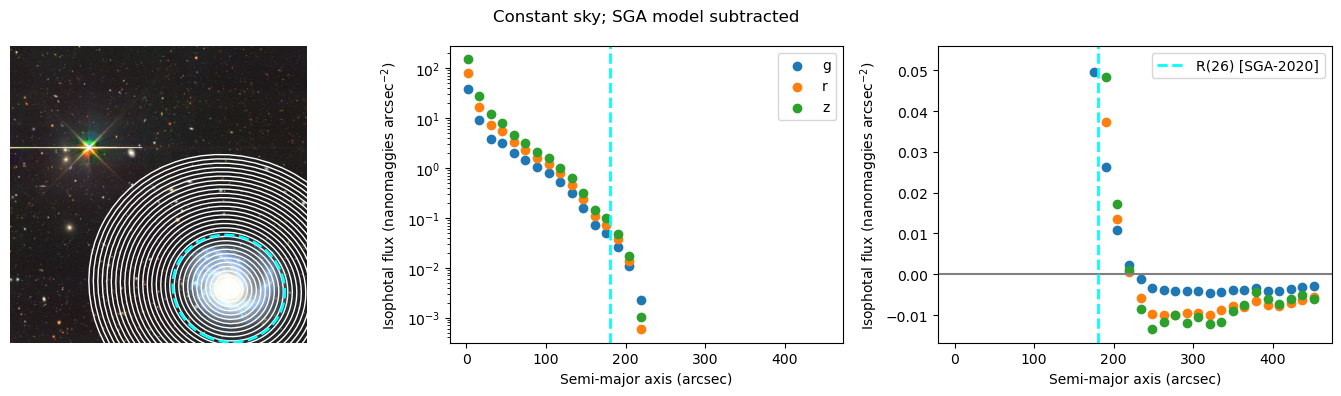

In [18]:
qa_ellipse(data1, jpg1, refgeo, nsma=nsma, title='Constant sky; SGA model subtracted')

#### Constant sky; SGA model not subtracted

In [19]:
datadir2 = '/pscratch/sd/d/dstn/SGA2025-const-sky/coadd/184/1847p145/'
refimg2, imgs2, jpg2, _, _, _ = read_data(datadir2)

In [20]:
%time data2 = do_ellipse(bands, imgs2, refgeo, nsma=nsma, mp=8)

Working on band g
Working on band r
Working on band z
CPU times: user 8.34 s, sys: 22.9 s, total: 31.2 s
Wall time: 3min 27s


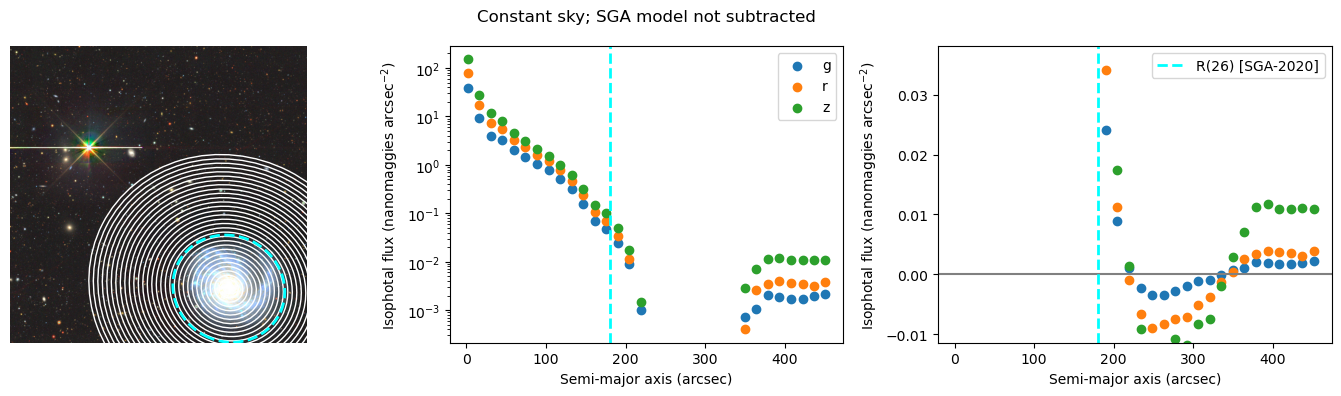

In [21]:
qa_ellipse(data2, jpg2, refgeo, nsma=nsma, title='Constant sky; SGA model not subtracted')

In [70]:
datadir3 = '/pscratch/sd/d/dstn/dr11-sky/constant-no-sga/coadd/184/1847p145'
refimg3, imgs3, jpg3, _, _, _ = read_data(datadir3)

In [71]:
%time data3 = do_ellipse(bands, imgs3, refgeo, nsma=nsma, mp=8)

Working on band g
Working on band r
Working on band z
CPU times: user 9 s, sys: 23 s, total: 32 s
Wall time: 3min 14s


In [72]:
data3['sma_r'][data3['intens_r'] < 0.], refgeo.sma

(array([ 836.70856,  892.02997,  947.3514 , 1002.6728 , 1057.9943 ,
        1113.3157 , 1168.6371 , 1223.9585 , 1279.2799 , 1334.6013 ,
        1389.9227 , 1445.2441 , 1500.5656 , 1555.887  , 1611.2084 ,
        1666.5298 , 1721.8512 ], dtype=float32),
 688.740458015267)

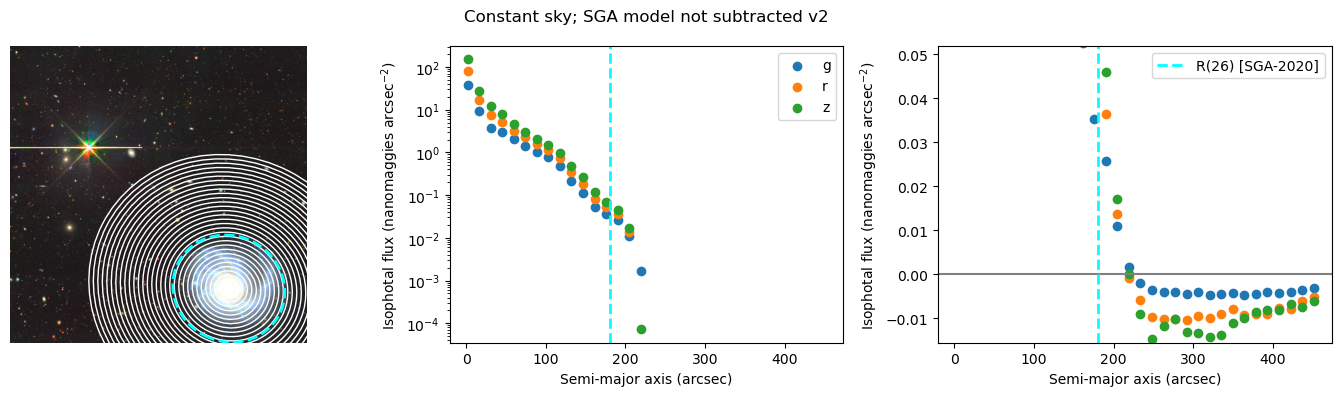

In [73]:
qa_ellipse(data3, jpg3, refgeo, nsma=nsma, title='Constant sky; SGA model not subtracted v2')

In [74]:
datadir1, datadir2, datadir3

('/pscratch/sd/d/dstn/dr11-sky/constant/coadd/184/1847p145',
 '/pscratch/sd/d/dstn/SGA2025-const-sky/coadd/184/1847p145/',
 '/pscratch/sd/d/dstn/dr11-sky/constant-no-sga/coadd/184/1847p145')